In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [40]:
def bin_data(df, col, bins, labels):
    df['binned'] = pd.cut(df[col], bins=bins, labels=labels)
    a = df.groupby('binned').size()
    return a.values/len(df)

def plot_couple(data, labels, xlabels, title, orientation = False, filename="img.png"):
    bar_width = 0.8 #ampiezza barra
    opacity_1 = 0.4 #opacità barra
    opacity_2 = 0.8
    
    if(orientation): 
        plt.bar(labels, data, bar_width, alpha=opacity_2, color='g')
        #plt.bar(labels, data[1], bar_width, alpha=opacity_1, color='b', label=legend[1])
        plt.xticks(labels, xlabels, rotation='vertical') 
    else:
        plt.barh(labels, data[0], alpha=opacity_2, color='g', label=legend[0])
        plt.barh(labels, data[1], alpha=opacity_1, color='b', label=legend[1])
    #plt.yticks(labels, xlabels, rotation=rotation) 
    
    #plt.legend(loc='upper right')
    
    plt.title(title)
    plt.savefig(filename)
    plt.show()
    plt.close()

In [41]:
df = pd.read_csv("data/avro-issues.csv")
df.resolutiondate = pd.to_datetime(df['resolutiondate'])
df.updated = pd.to_datetime(df['updated'])
df.created = pd.to_datetime(df['created'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 17 columns):
status                    1458 non-null object
priority                  1458 non-null object
updated                   1458 non-null datetime64[ns]
issue_type                1458 non-null object
reporter                  1458 non-null object
created                   1458 non-null datetime64[ns]
resolutiondate            1134 non-null datetime64[ns]
vote_count                1458 non-null int64
project                   1458 non-null object
assignee                  1063 non-null object
comment_count             1458 non-null int64
key                       1458 non-null object
description_length        1388 non-null float64
summary_length            1458 non-null int64
watch_count               1458 non-null int64
resolution                1134 non-null object
days_in_current_status    1458 non-null float64
dtypes: datetime64[ns](3), float64(2), int64(4), object(8)
memory usage:

In [42]:
df.head()

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status
0,Open,Major,2013-07-02 02:33:35.279,Bug,keyer,2013-07-01 11:38:36.150,NaT,0,AVRO,NaN,2,AVRO-1350,3042.0,46,1,NaN,231.248588
1,Resolved,Critical,2013-06-20 16:41:00.043,Bug,scott_carey,2013-06-20 16:29:17.709,2013-06-20 16:41:00.024,0,AVRO,NaN,2,AVRO-1349,41.0,43,2,Fixed,242.038590
2,Resolved,Major,2013-06-20 17:38:07.697,Bug,skye,2013-06-06 17:41:12.389,2013-06-20 17:18:00.789,0,AVRO,skye,6,AVRO-1346,528.0,55,6,Fixed,242.012886
3,Open,Minor,2013-05-30 22:07:02.491,Improvement,davidtaylor,2013-05-30 22:02:52.515,NaT,0,AVRO,NaN,1,AVRO-1342,312.0,44,1,NaN,262.815066
4,Open,Minor,2013-05-25 05:35:30.283,Improvement,jdonofrio,2013-05-25 05:35:30.283,NaT,0,AVRO,NaN,0,AVRO-1340,559.0,97,1,NaN,268.500740


## Analisi variabili

### Variabile dipendente **closing_time**

Poichè il task è quello di predire il tempo neccessario alla chiusura di un alert, creiamo la variabile dipendente **closing_time**.

Poichè non abbiamo informazioni circa la data di chiusura di un issue, ma solo la data della sua risoluzione, consideriamo un issue chiuso solo ha una data di risoluzione (i.e. **resolutiondate** diverso da null). Quindi la variabile closing_time è calcolata come differenza in giorni tra il tempo di creazione di un issue e il suo tempo di risoluzione. Verranno considerati "Closed" gli issue aventi valore *Resolved* (40 data record) e *Closed* (1094 data record) per la variabile **status**

In particolare si osserva come i tempi di risoluzione variano in un intervallo da 0 a 952 giorni. Tuttavia si osserva come la maggiorparte delle risoluzioni avvengono entro il mese. 

Infine analizzando la distribuzione della variabile **closing_time** si osserva che tutti i data record con valori > 800 possono essere considerati outliers.

### Variabile dipendente **resolution_days**

Differentemente dalla variabile **closing_time**, la variabile **resolution_days** e di tipo categorico e codifica l'intervallo di giorni entro cui un issue verrà risolto.


Frequency of 5 Categories for varible status
Closed             1094
Open                279
Patch Available      42
Resolved             40
Reopened              3
Name: status, dtype: int64


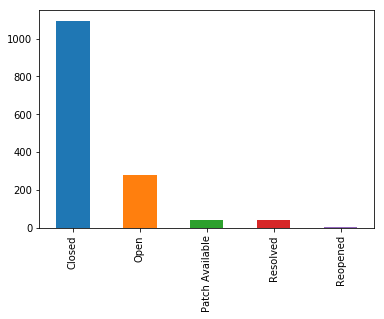

In [43]:
col = "status"
#print(df["status"].describe(include=['O']))

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
print (count[:20])

df[col].value_counts().plot(kind='bar')

In [44]:
df = df[(~df["resolutiondate"].isnull()) & (~df["created"].isnull())]
df.shape

(1134, 17)

In [45]:
df["closing_time"] = df['resolutiondate'] - df["created"]
df["closing_time"] = df["closing_time"].astype('timedelta64[D]')

In [46]:
df["closing_time"].describe()

count    1134.000000
mean       46.193122
std       120.945111
min         0.000000
25%         1.000000
50%         6.000000
75%        29.000000
max       952.000000
Name: closing_time, dtype: float64

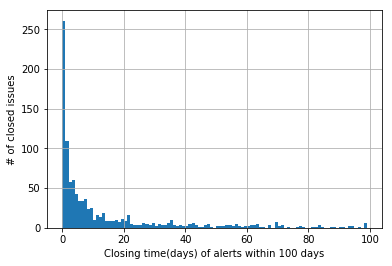

In [47]:
df["closing_time"].hist(bins=range(0, 100, 1))
plt.xlabel('Closing time(days) of alerts within 100 days')
plt.ylabel('# of closed issues');

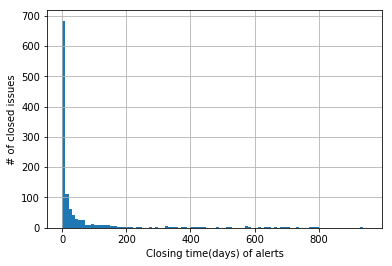

In [48]:
df["closing_time"].hist(bins=range(0, 953, 10))
plt.xlabel('Closing time(days) of alerts')
plt.ylabel('# of closed issues');

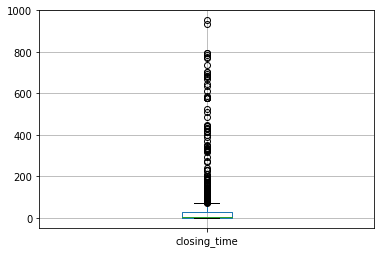

In [49]:
df.boxplot(["closing_time"])

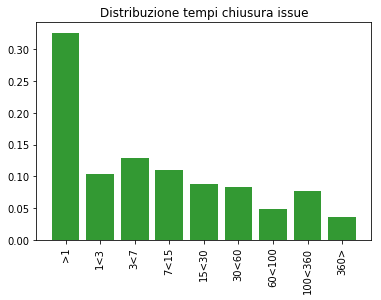

In [50]:
bins = [-0.99, 1, 3, 7, 15, 30, 60, 100, 360, 1000]
labels = list(range(0,9))
xlabels = [">1",  "1<3","3<7", "7<15", "15<30", "30<60", "60<100", "100<360","360>"]

x1 = bin_data(df,'closing_time', bins, labels)
plot_couple(x1, labels, xlabels, "Distribuzione tempi chiusura issue", orientation=True)

## Analisi variabili indipendenti

Si analizzano di seguito le variabili indipendenti che parteciperanno nel processo di apprendimento del modello. In particolare, verranno escluse dalla costruzione del modello le seguenti variabili:

- key: id univoco;
- updated: gli update di tutti gli issue sono successivi alla data di risoluzione;
- resolutiondate: utilizzata per calcolare la variabile dipendente;
- project: monovalore (i.e. nome progetto);
- days_in_current_status: la variabile non è significativa rispetto al task di predizione. In particolare, poichè nell'analisi verranno analizzate solo le istanze aventi status *Resolved* e *Closed*, questa variabile conterrà solo informazioni relative al tempo intercorso da oggi (?) al giorno in cui l'issue è stato risolto o chiuso.


### Variabile Reporter

La variabile è caratterizzata da 245 valori distinti. Tuttavia questa sembra avere una long tail distribution, ossia ci sono pochi utenti che pubblicano molti issue e molti utenti che pubblicano pochi issue. 

Per questa ragione, riduciamo il numero di feature distinte utilizzando un binning basato sui quantili. In particolare sostituiamo il nome del reporter con il valore di default *Other* se il numero di issue pubblicati è minore o uguale a 3 (i.e. 75-percentile).


Frequency of 245 Categories for varible reporter
cutting         157
hammer           67
thiru_mg         66
massie           55
philip           43
scott_carey      38
sbanacho         35
brucem           33
dcreager         29
jmhodges         21
tomwhite         16
pwendell         14
phunt            13
vnadkarni        13
sharadag         13
mpugachev        12
lmartinking      11
jbaldassari      11
qwertymaniac      9
urandom           9
Name: reporter, dtype: int64


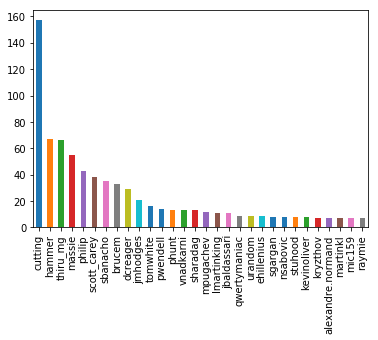

In [51]:
col = "reporter"
#print(df["status"].describe(include=['O']))

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
print (count[:20])

df[col].value_counts()[:30].plot(kind='bar')

In [52]:
df[col].value_counts().describe()

count    245.000000
mean       4.628571
std       13.008068
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max      157.000000
Name: reporter, dtype: float64

In [53]:
value_counts = df[col].value_counts()
reporters = value_counts[value_counts > 3].index.values
df['transformed_reporters'] = df[col].map(lambda x: x if x in reporters else 'other')

In [54]:
df.head()

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,comment_count,key,description_length,summary_length,watch_count,resolution,days_in_current_status,closing_time,binned,transformed_reporters
1,Resolved,Critical,2013-06-20 16:41:00.043,Bug,scott_carey,2013-06-20 16:29:17.709,2013-06-20 16:41:00.024,0,AVRO,NaN,2,AVRO-1349,41.0,43,2,Fixed,242.038590,0.0,0,scott_carey
2,Resolved,Major,2013-06-20 17:38:07.697,Bug,skye,2013-06-06 17:41:12.389,2013-06-20 17:18:00.789,0,AVRO,skye,6,AVRO-1346,528.0,55,6,Fixed,242.012886,13.0,3,other
6,Closed,Minor,2013-08-20 17:46:04.208,Improvement,bdechoux,2013-05-21 21:33:17.274,2013-08-07 19:23:23.544,0,AVRO,bdechoux,7,AVRO-1337,279.0,40,5,Fixed,180.993403,77.0,6,other
8,Closed,Critical,2013-08-20 17:46:04.078,Bug,kirwin,2013-05-08 15:48:38.228,2013-05-09 21:04:56.888,0,AVRO,cutting,4,AVRO-1326,1025.0,45,3,Fixed,180.993404,1.0,0,other
12,Resolved,Minor,2013-05-28 14:01:43.456,New Feature,vince83,2013-05-15 10:38:51.771,2013-05-28 13:59:56.490,6,AVRO,vince83,4,AVRO-1330,1260.0,45,4,Duplicate,265.150436,13.0,3,vince83


### Variabile Assignee


Frequency of 147 Categories for varible assignee
cutting         270
thiru_mg         82
massie           52
dcreager         50
hammer           42
philip           37
scott_carey      37
sbanacho         36
jmhodges         20
brucem           20
pwendell         16
jbaldassari      14
tomwhite         14
sharadag         13
sgargan           8
qwertymaniac      8
nsabovic          7
martinkl          7
robair            6
kryzthov          6
Name: assignee, dtype: int64


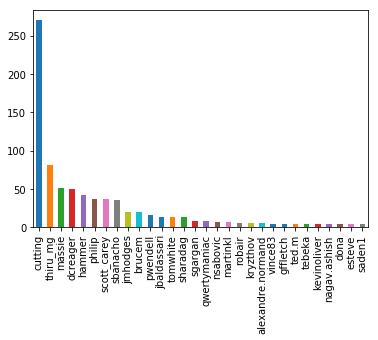

In [55]:
col = "assignee"
#print(df["status"].describe(include=['O']))

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
print (count[:20])

df[col].value_counts()[:30].plot(kind='bar')

In [56]:
df[col].value_counts().describe()

count    147.000000
mean       6.707483
std       24.348838
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max      270.000000
Name: assignee, dtype: float64

In [57]:
value_counts = df[col].value_counts()
assigned = value_counts[value_counts > 3].index.values
df['transformed_assigned'] = df[col].map(lambda x: x if x in assigned else 'other')

In [58]:
df.head(3)

,status,priority,updated,issue_type,reporter,created,resolutiondate,vote_count,project,assignee,...,key,description_length,summary_length,watch_count,resolution,days_in_current_status,closing_time,binned,transformed_reporters,transformed_assigned
1,Resolved,Critical,2013-06-20 16:41:00.043,Bug,scott_carey,2013-06-20 16:29:17.709,2013-06-20 16:41:00.024,0,AVRO,NaN,...,AVRO-1349,41.0,43,2,Fixed,242.038590,0.0,0,scott_carey,other
2,Resolved,Major,2013-06-20 17:38:07.697,Bug,skye,2013-06-06 17:41:12.389,2013-06-20 17:18:00.789,0,AVRO,skye,...,AVRO-1346,528.0,55,6,Fixed,242.012886,13.0,3,other,other
6,Closed,Minor,2013-08-20 17:46:04.208,Improvement,bdechoux,2013-05-21 21:33:17.274,2013-08-07 19:23:23.544,0,AVRO,bdechoux,...,AVRO-1337,279.0,40,5,Fixed,180.993403,77.0,6,other,other


La seguente tabella mostra, attraverso matrice di confusione, la correlazione tra i reporter e gli assigner. In particolare si osserva che in il main contributor *Cutting* generalmente risolve sia gli issue da lui riportati che quelli riportati dal second contributor *Hammer* e da reporter occasionali (ossia da quegli utenti che hanno pubblicato un numero di issue inferiore a 3). Invece analizzando i top 30 raggruppamenti assigner-reporter si osserva che in generale i maggiori contributors pubblicano e risolvono issue. 

Si riporta, per ragioni di spazio, la matrice di confusione per i top 15 reporter in termini di issue risolti. 

In [59]:
#Questa tabella mostra il raggruppamento tra assegnatari e reporter
confusion_matrix = df.groupby(["transformed_assigned", "transformed_reporters"]).size().sort_values(ascending = False)[:30].unstack(fill_value=0)
confusion_matrix = confusion_matrix.reindex_axis(confusion_matrix.sum().sort_values(ascending = False).index, axis=1)
cols = confusion_matrix.columns[:15]
confusion_matrix[cols]

/home/fabiana/miniconda3/envs/anac/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


transformed_reporters,other,cutting,hammer,thiru_mg,massie,philip,sbanacho,brucem,scott_carey,dcreager,jmhodges,pwendell,mpugachev,tomwhite,jbaldassari
transformed_assigned,,,,,,,,,,,,,,,
other,190,8,11,0,0,0,0,0,0,0,0,0,12,0,0
cutting,63,135,14,0,0,0,0,0,0,0,0,0,0,0,0
thiru_mg,10,0,0,60,0,0,0,0,0,0,0,0,0,0,0
massie,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0
hammer,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0
philip,0,0,0,0,0,36,0,0,0,0,0,0,0,0,0
sbanacho,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0
scott_carey,0,0,0,0,0,0,0,0,28,0,0,0,0,0,0
dcreager,0,0,0,0,0,0,0,11,0,28,0,0,0,0,0


### Variabile VOTE_COUNT


Frequency of 9 Categories for varible vote_count
0    1058
1      59
2       8
6       3
5       2
9       1
8       1
7       1
4       1
Name: vote_count, dtype: int64


Text(0,0.5,'Numero commenti in scala logaritmica')

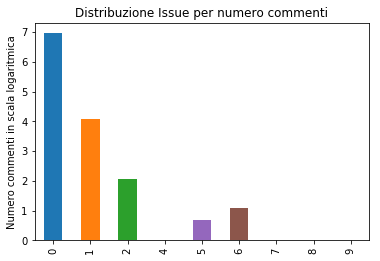

In [60]:
col = "vote_count"
#print(df["status"].describe(include=['O']))

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
print (count[:20])

df[col].value_counts().sort_index().map(lambda x: np.log(x)).plot(kind='bar')
plt.title("Distribuzione Issue per numero commenti")
plt.ylabel("Numero commenti in scala logaritmica")

count    1134.000000
mean        0.115520
std         0.625909
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: vote_count, dtype: float64

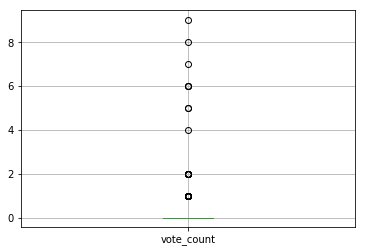

In [61]:
df.boxplot([col])
df[col].describe()

### Variabile COMMENT_COUNT

In generale, il numero di commenti per issue si attesta tra i 2 e i 7 commenti. Inoltre ci sono solo 8 issue caratterizzati da un numero di commenti superiore a 40.  


Frequency of 41 Categories for varible comment_count
2     173
3     168
1     146
4     139
5      95
6      83
7      55
8      39
9      39
10     36
Name: comment_count, dtype: int64


Text(0.5,1,'Distribuzione Issue per numero commenti')

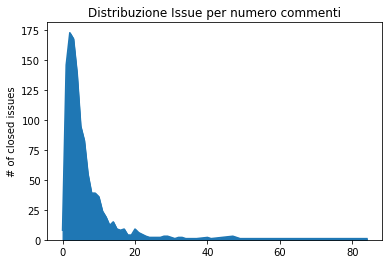

In [62]:
col = "comment_count"

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
print (count[:10])

#df[col].hist(bins=range(0, 84, 1))
df[col].value_counts().sort_index().plot.area()

plt.ylabel('# of closed issues');
plt.title("Distribuzione Issue per numero commenti")

count    1134.000000
mean        6.041446
std         6.880075
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        84.000000
Name: comment_count, dtype: float64

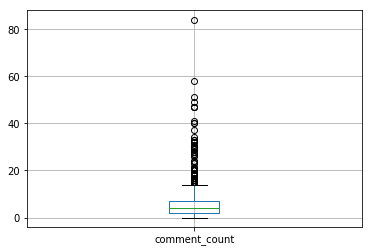

In [63]:
df.boxplot([col])
df[col].describe()

### Variabile description_length
La variabile contiene informazioni circa la lunghezza della descrizione di un issue. Tuttavia non si hanno informazioni sull'unità di misura della variabile. Osservando i risultati si assume che la variabile descrive la lunghezza della descrizione in termini di numero di caratteri.

In generale, la lunghezza della descrizione di un issue si attesta tra circa 150 e 600 caratteri. Inoltre ci sono solo 12 issue caratterizzati da una descrizione superiore ai 4000 caratteri. Quindi questi datarecord possono essere considerati degli outlier rispetto a questa variabile.  



Frequency of 633 Categories for varible description_length


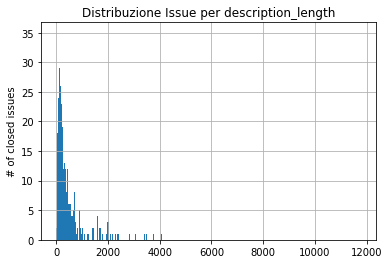

In [409]:
col = "description_length"

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
#print (count[:10])


df[col].hist(bins=range(0, 11763, 10))
#df[col].value_counts().sort_index().plot.line()

plt.ylabel('# of closed issues');
plt.title("Distribuzione Issue per " + col)
plt.show()

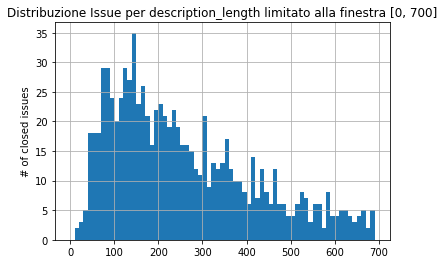

In [411]:
df[col].hist(bins=range(0, 700, 10))

plt.ylabel('# of closed issues');
plt.title("Distribuzione Issue per " + col + " limitato alla finestra [0, 700]")
plt.show()

count     1079.000000
mean       552.630213
std        869.996011
min         16.000000
25%        146.500000
50%        279.000000
75%        569.500000
max      11762.000000
Name: description_length, dtype: float64

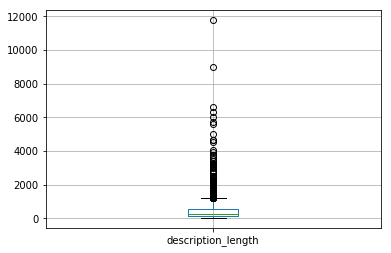

In [66]:
df.boxplot([col])
df[col].describe()

### Variabile SUMMARY_LENGTH
Come nel caso della variabile description_length assumiamo che la variabile descrive la lunghezza del summary in termine di numero di caratteri. 

La variabile ha distribuzione normale. Inoltre ci sono 4 issue caratterizzati da un summary superiore ai 120 caratteri. Tali data record possono essere considerati degli outlier rispetto alla variabile in esame.


Frequency of 110 Categories for varible summary_length


Text(0.5,1,'Distribuzione Issue per numero commenti')

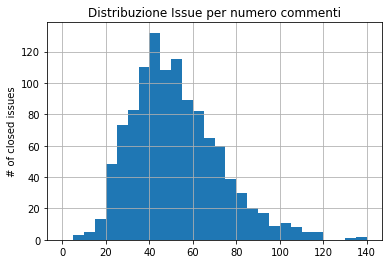

In [67]:
col = "summary_length"

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
#print (count[:10])

#df[col].value_counts().sort_index().plot.line()
df[col].hist(bins=range(0, 145, 5))

plt.ylabel('# of closed issues');
plt.title("Distribuzione Issue per numero commenti")

count    1134.000000
mean       51.893298
std        20.560635
min         8.000000
25%        37.000000
50%        49.000000
75%        64.000000
max       144.000000
Name: summary_length, dtype: float64

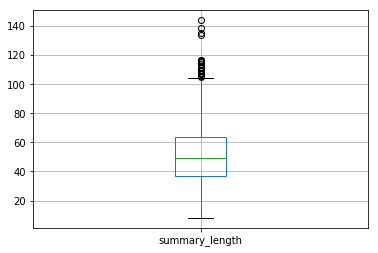

In [68]:
df.boxplot([col])
df[col].describe()

### Variabile WATCH_COUNT

La variabile contiene informazioni circa il numero di utenti che osservano un issue. In generale, gli issue hanno un numero di osservatori variabili tra 0 e 2 utenti. Inoltre si osserva come tutte le istanze con un numero di osservatori maggiore a 15 possono essere considerati degli outlier.

<!--Inoltre si osserva una correlazione tra il numero di osservatori e il tipo di issue:
- Per issue con un numero di osservatori inferiore a 5, sono di tipo *Bug* o *Improvement*;
- Gli issue con un numero di osservatori maggiore a 5, sono per lo più di tipo *New Feature*.
Questa correlazione è in linea con la politica di Github che assegna priorità maggiore a issue con un numero elevato di watching<--> 



Frequency of 17 distinct values for the variable watch_count


Text(0.5,1,'Distribuzione Issue per numero commenti')

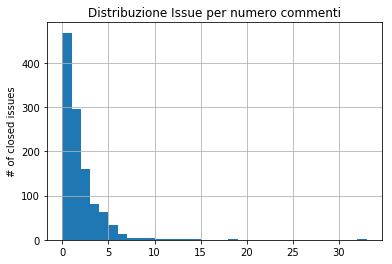

In [69]:
col = "watch_count"

count = df[col].value_counts()
print ('\nFrequency of %d distinct values for the variable %s'%(len(count), col))
#print (count[:10])


df[col].hist(bins=range(0, 34, 1))

plt.ylabel('# of closed issues');
plt.title("Distribuzione Issue per numero commenti")

count    1134.000000
mean        1.388889
std         2.068445
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        33.000000
Name: watch_count, dtype: float64

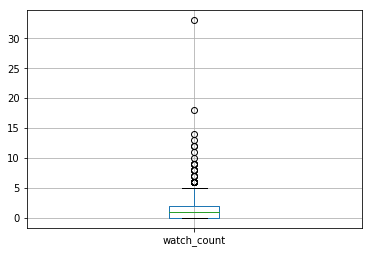

In [70]:
df.boxplot([col])
df[col].describe()

### Variabile PRIORITY


Frequency of 5 Categories for varible priority
Major       848
Minor       189
Blocker      38
Trivial      31
Critical     28
Name: priority, dtype: int64


Text(0.5,1,'Distribuzione Issue per priorità')

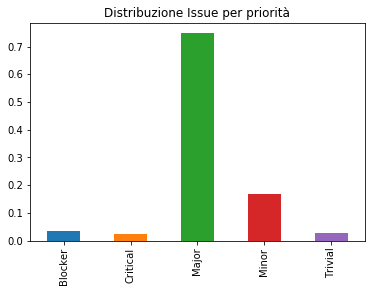

In [71]:
col = "priority"
#print(df["status"].describe(include=['O']))

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
print (count[:20])

#df[col].value_counts().sort_index().plot(kind='bar')
(df[col].value_counts() / len(df)).sort_index().plot(kind='bar')
plt.title("Distribuzione Issue per priorità")
#plt.ylabel("Numero commenti in scala logaritmica")

### Variabile ISSUE_TYPE


Frequency of 7 Categories for varible issue_type
Bug            509
Improvement    404
New Feature    149
Sub-task        32
Test            21
Task            13
Wish             6
Name: issue_type, dtype: int64


Text(0.5,1,'Distribuzione Issue per priorità')

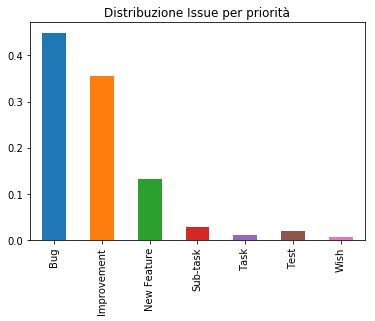

In [372]:
col = "issue_type"
#print(df["status"].describe(include=['O']))

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
print (count[:20])

#df[col].value_counts().sort_index().plot(kind='bar')
(df[col].value_counts() / len(df)).sort_index().plot(kind='bar')
plt.title("Distribuzione Issue per priorità")

## Analisi Bivariata

### Analisi Variabile Dipendente CLOSING_TIME con Variabili Indipendenti Numeriche

Per analizzare la correlazioni, utilizziamo il coefficiente di Pearson. Questa è la misura più ampiamente usata nell'analisi statistica dei dati e calcola l'associazione lineare tra variabili continue. Si ricorda tuttavia che il coeff. di Pearson e sensibile agli outliers.

In [74]:
numerical_cols = ["vote_count", "comment_count", "description_length", "summary_length", "watch_count"]

In [75]:
df[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1134 entries, 1 to 1455
Data columns (total 5 columns):
vote_count            1134 non-null int64
comment_count         1134 non-null int64
description_length    1079 non-null float64
summary_length        1134 non-null int64
watch_count           1134 non-null int64
dtypes: float64(1), int64(4)
memory usage: 53.2 KB


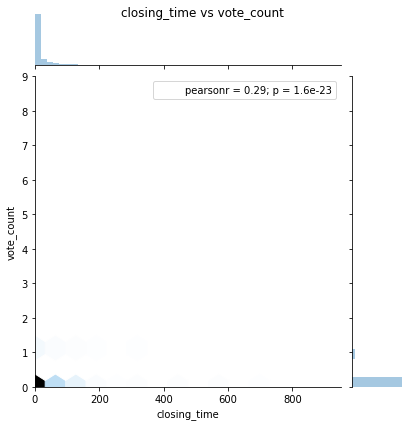

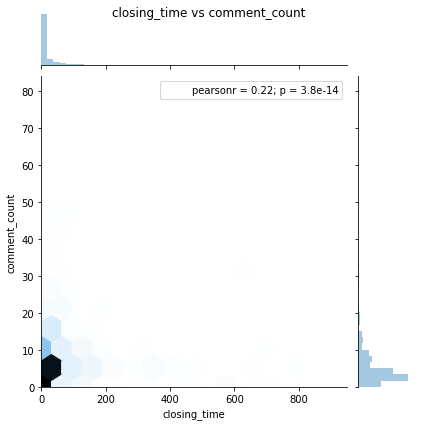

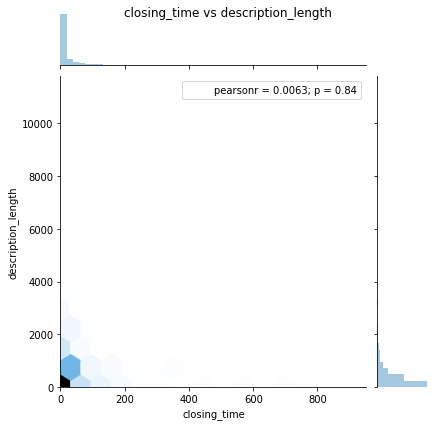

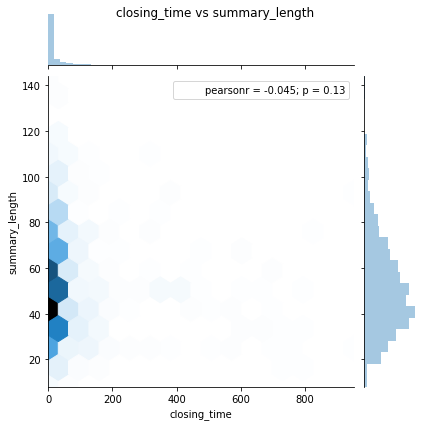

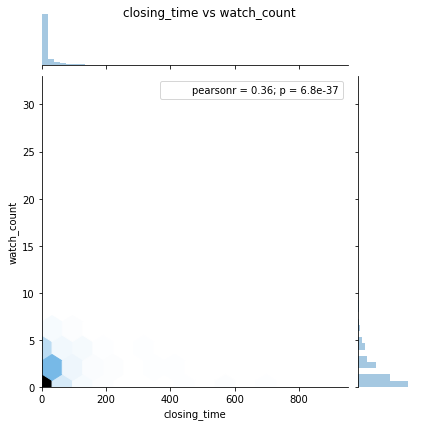

In [99]:
import seaborn as sns

for i in range(0,len(numerical_cols)):
    
    #df.plot.hexbin(x='closing_time', y= numerical_cols[i], gridsize=15, sharex= False)
    lm = sns.jointplot(x='closing_time', y=numerical_cols[i], data=df, kind='hex', gridsize=15)
    
    # Access the Figure
    fig = lm.fig 

    # Add a title to the Figure
    fig.suptitle('closing_time vs ' + numerical_cols[i], fontsize=12)

    # Show the plot
    plt.show()

### Analisi Variabile Dipendente CLOSING_TIME con Variabili Indipendenti Categoriche

####################################################################################################

Analisi Bivariata closing_time-status 



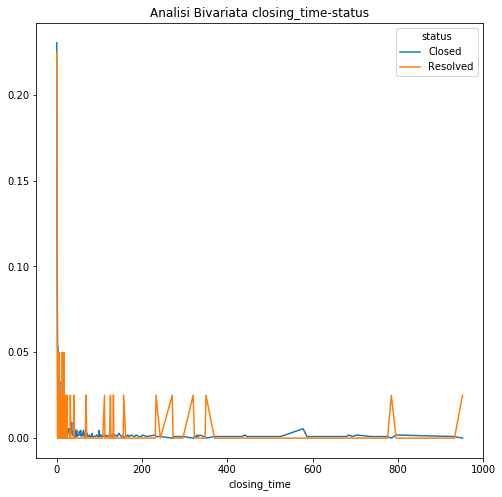

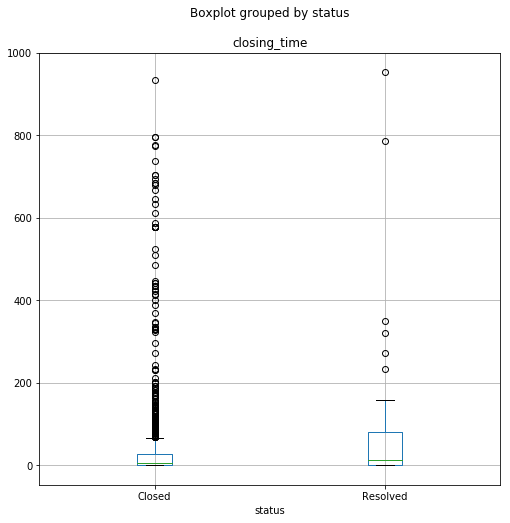

####################################################################################################
####################################################################################################

Analisi Bivariata closing_time-priority 



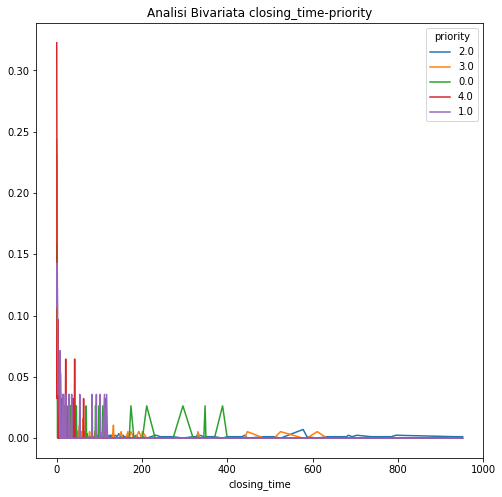

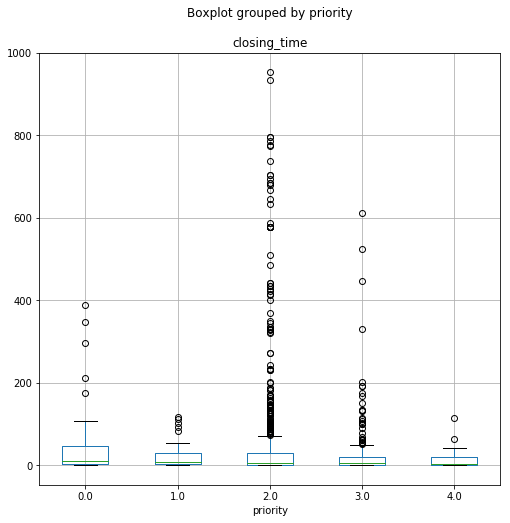

####################################################################################################
####################################################################################################

Analisi Bivariata closing_time-issue_type 



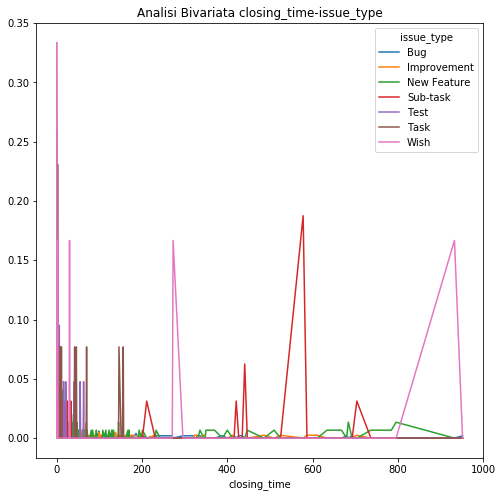

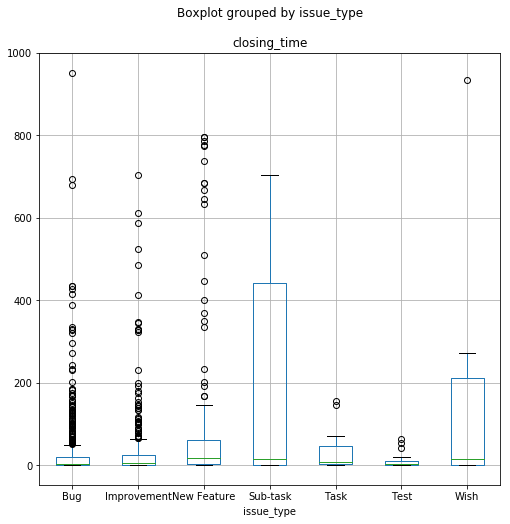

####################################################################################################
####################################################################################################

Analisi Bivariata closing_time-resolution 



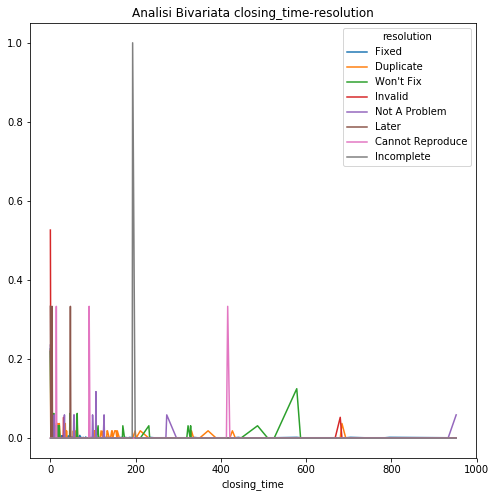

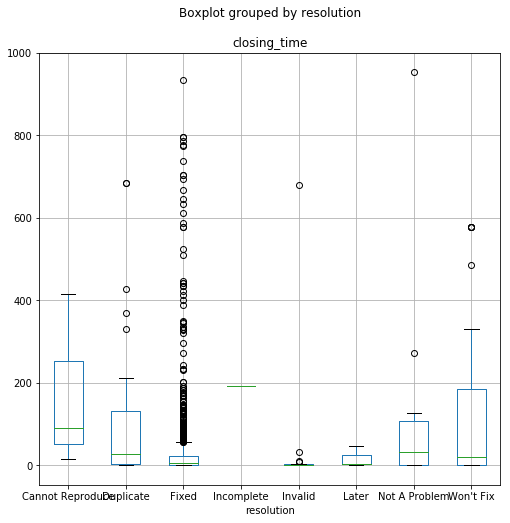

####################################################################################################


In [461]:
import operator

categorical_columns = ['status', 'priority', 'issue_type', 'resolution']

subset = df #df[df["closing_time"] < 60]
for c in categorical_columns:
    x_name = "closing_time"
    x = subset[x_name].values
    y = subset[c].values
        
    confusion_matrix = subset.groupby([x_name, c]).size().sort_values(ascending = False).unstack(fill_value=0)
    confusion_matrix = confusion_matrix.reindex_axis(confusion_matrix.sum().sort_values(ascending = False).index, axis=1)
    
    confusion_matrix = confusion_matrix / confusion_matrix.sum()
    print("####################################################################################################")
    print("\n\033[1m" + "Analisi Bivariata closing_time" + "-" + c + "\033[0;0m \n")

    confusion_matrix.plot.line(title = "Analisi Bivariata closing_time" + "-" + c, figsize= (8,8))
    df.boxplot(column="closing_time",by= c, figsize= (8,8)) 

    plt.show()
    print("####################################################################################################")
    

### Analisi Bivariata Variabili Indipendenti numeriche

In questa sezione si analizza la correlazione (in termine di coefficiente di Pearson) tra le variabili indipendenti numeriche.

In [467]:
df.corr()  # priority è una variabile categorica ordinale con i seguenti valori in ordine lessicografico ['Blocker', 'Critical', 'Major', 'Minor', 'Trivial']
df['priority'] = df['priority'].astype('category')

#array codifica l'ordinamento, in questo caso l'ordinamento lessicografico codifica anche quello semantico
df['priority'].cat.categories = [0,1,2,3,4]
df['priority'] = df['priority'].astype('float')

#df['binned'].cat.categories = [0,1,2,3,4,5,6,7,8]
#df['binned'] = df['binned'].astype('float')
df.corr()

,priority,vote_count,comment_count,description_length,summary_length,watch_count,days_in_current_status,closing_time,binned
priority,1.000000,-0.010861,-0.111093,-0.159947,-0.055906,-0.014624,-0.086918,-0.054638,-0.066214
vote_count,-0.010861,1.000000,0.329690,0.075419,-0.064196,0.495658,-0.133506,0.290720,0.227880
comment_count,-0.111093,0.329690,1.000000,0.145244,0.043751,0.514006,-0.169351,0.222131,0.367803
description_length,-0.159947,0.075419,0.145244,1.000000,0.216253,0.073928,-0.162450,0.006308,0.092630
summary_length,-0.055906,-0.064196,0.043751,0.216253,1.000000,0.002450,-0.121382,-0.044868,0.006116
watch_count,-0.014624,0.495658,0.514006,0.073928,0.002450,1.000000,-0.457087,0.364185,0.357824
days_in_current_status,-0.086918,-0.133506,-0.169351,-0.162450,-0.121382,-0.457087,1.000000,-0.225172,-0.243257
closing_time,-0.054638,0.290720,0.222131,0.006308,-0.044868,0.364185,-0.225172,1.000000,0.656894
binned,-0.066214,0.227880,0.367803,0.092630,0.006116,0.357824,-0.243257,0.656894,1.000000


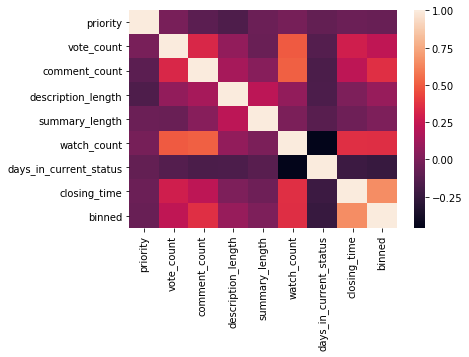

In [455]:
import seaborn as sns
sns.heatmap(df.corr())

In [226]:
#import scipy.stats
#import numpy
#
#for i in range(0,len(numerical_cols)):
#    
#    #pearson richiede che le variabili x,y con contengano valori nulli
#    x = df["closing_time"].values
#    y = df[numerical_cols[i]].values
#    nas = np.logical_or(np.isnan(x), np.isnan(y))
#    p = numpy.corrcoef(x[~nas], y[~nas])[0,1]
#        #print(p)
#    print("pearson = " + str(p))
#    #df.plot.scatter(x='closing_time', y= numerical_cols[i])
#    df.plot.hexbin(x='closing_time', y= numerical_cols[i], gridsize=15, sharex= False)
#    plt.show()

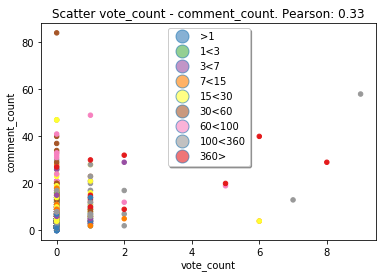

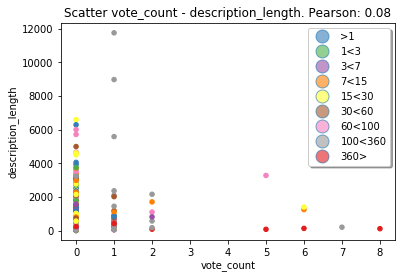

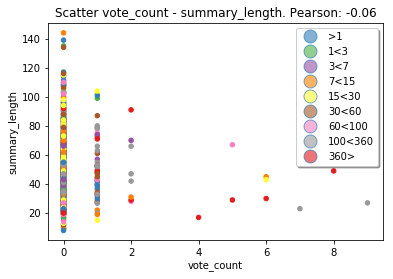

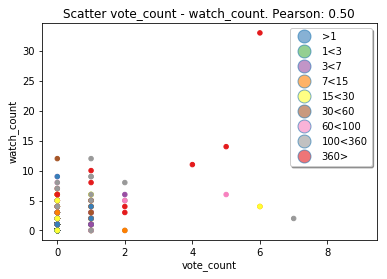

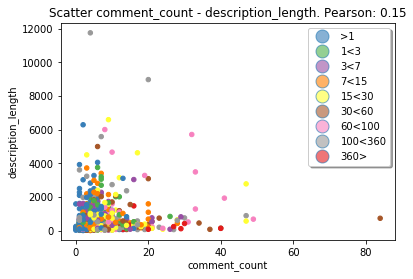

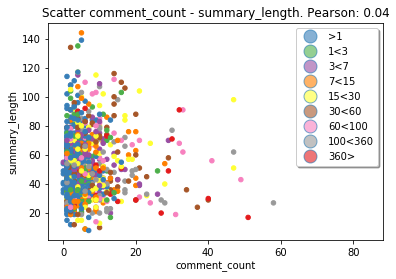

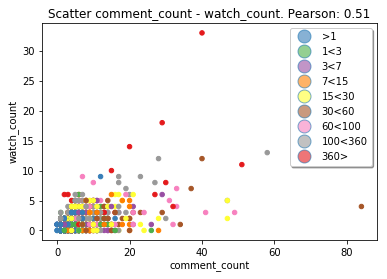

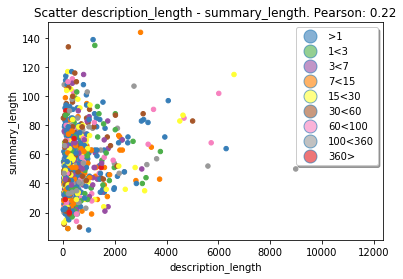

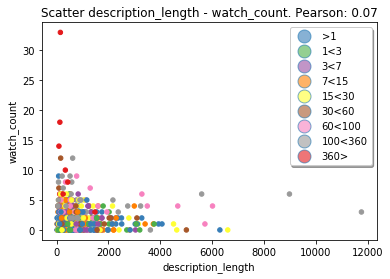

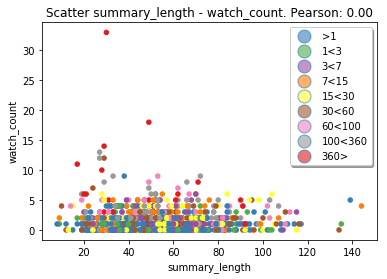

In [442]:
## Questo scatter plox mostra le correlazioni tra 2 variabili numeriche e setta il colore dei punti in base alla label

import scipy.stats
import numpy
import matplotlib.lines as mlines

# color palette 9-class Dark2, from ColorBrewer2: http://colorbrewer2.org/
palette = ['#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999', '#e41a1c']

classes = range(0, len(palette))
colors = dict(zip(classes, palette))

for i in range(0,len(numerical_cols)-1):
    for j in range(i +1, len(numerical_cols)):
        
        
        #pearson richiede che le variabili x,y con contengano valori nulli
        x = df[numerical_cols[i]].values
        y = df[numerical_cols[j]].values
        nas = np.logical_or(np.isnan(x), np.isnan(y))
        p = numpy.corrcoef(x[~nas], y[~nas])[0,1]
        #print(p)
        df.plot.scatter(x=numerical_cols[i], y= numerical_cols[j], c=df['binned'].apply(lambda x: colors[x]))
        
        legend1_line2d = list()
        for step in range(len(palette)):
            legend1_line2d.append(mlines.Line2D([0], [0],
                                        linestyle='none',
                                        marker='o',
                                        alpha=0.6,
                                        markersize=13,
                                        markerfacecolor=palette[step]))
 
        legend1 = plt.legend(legend1_line2d,
                     #classes,
                     xlabels,
                     numpoints=1,
                     #fontsize=22,
                     loc='best',
                     shadow=True)
        plt.title("Scatter " + numerical_cols[i] + " - "+ numerical_cols[j] + ". Pearson: "+ "{0:.2f}".format(p))
        plt.show()

### Analisi Variabile Dipendente binned_days  e Variabili Categoriche

####################################################################################################

Analisi Bivariata days-status 

     Closed  Resolved
0  0.328154     0.275
1  0.106033     0.050
2  0.130713     0.075
3  0.107861     0.150
4  0.085923     0.125
5  0.085009     0.050
6  0.049360     0.025
7  0.072212     0.200
8  0.034735     0.050


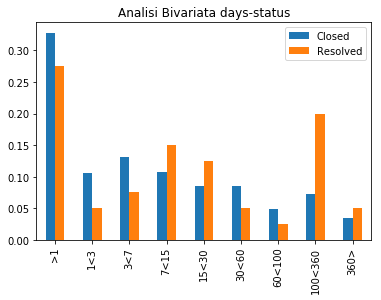

####################################################################################################
####################################################################################################

Analisi Bivariata days-priority 

        2.0       3.0      0.0       4.0       1.0
0  0.333726  0.327957  0.25000  0.523810  0.388889
1  0.106132  0.086022  0.00000  0.285714  0.222222
2  0.122642  0.172043  0.15625  0.000000  0.166667
3  0.096698  0.155914  0.18750  0.000000  0.222222
4  0.094340  0.048387  0.12500  0.000000  0.000000
5  0.081368  0.086022  0.12500  0.190476  0.000000
6  0.047170  0.048387  0.00000  0.000000  0.000000
7  0.075472  0.075269  0.15625  0.000000  0.000000
8  0.042453  0.000000  0.00000  0.000000  0.000000


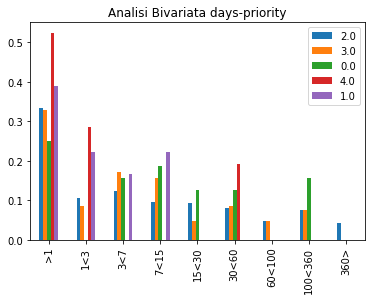

####################################################################################################
####################################################################################################

Analisi Bivariata days-issue_type 

        Bug  Improvement  New Feature  Sub-task  Test
0  0.377210     0.336683     0.161074  0.333333   1.0
1  0.117878     0.108040     0.053691  0.000000   0.0
2  0.119843     0.143216     0.147651  0.000000   0.0
3  0.102161     0.113065     0.114094  0.250000   0.0
4  0.070727     0.087940     0.147651  0.000000   0.0
5  0.076621     0.080402     0.120805  0.000000   0.0
6  0.041257     0.060302     0.053691  0.000000   0.0
7  0.078585     0.070352     0.100671  0.000000   0.0
8  0.015717     0.000000     0.100671  0.416667   0.0


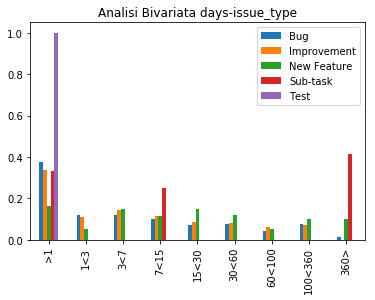

####################################################################################################
####################################################################################################

Analisi Bivariata days-resolution 

      Fixed  Duplicate  Won't Fix  Not A Problem   Invalid
0  0.326368   0.226415   0.290323       0.466667  0.866667
1  0.112438   0.056604   0.000000       0.000000  0.000000
2  0.142289   0.000000   0.000000       0.000000  0.000000
3  0.113433   0.056604   0.096774       0.000000  0.133333
4  0.086567   0.150943   0.129032       0.000000  0.000000
5  0.079602   0.132075   0.096774       0.200000  0.000000
6  0.048756   0.037736   0.064516       0.066667  0.000000
7  0.062687   0.264151   0.161290       0.266667  0.000000
8  0.027861   0.075472   0.161290       0.000000  0.000000


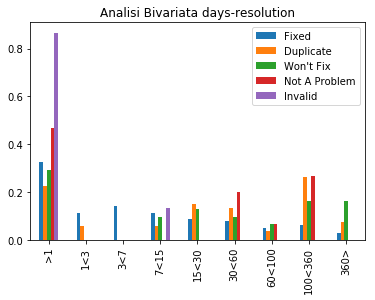

####################################################################################################
####################################################################################################

Analisi Bivariata days-vote_count 

          0         2         3         1         4         5         7  \
0  0.981081  0.958904  0.959677  0.983051  0.909091  0.905263  0.764706   
1  0.018919  0.034247  0.024194  0.016949  0.080808  0.094737  0.200000   
2  0.000000  0.006849  0.008065  0.000000  0.000000  0.000000  0.035294   
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
6  0.000000  0.000000  0.008065  0.000000  0.010101  0.000000  0.000000   

          6      8  
0  0.927273  0.700  
1  0.036364  0.150  
2  0.018182  0.050  
8  0.000000  0.025  
4  0.000000  0.025  
5  0.018182  0.025  
6  0.000000  

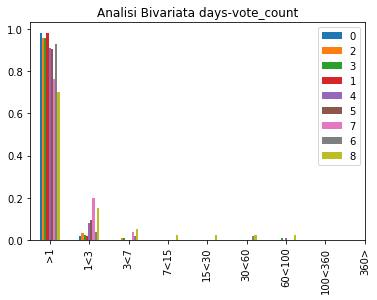

####################################################################################################


In [448]:
import operator

categorical_columns = ['status', 'priority', 'issue_type', 'resolution', 'vote_count']
days_uniques = sorted(df["binned"].unique().get_values())

for c in categorical_columns:
    c_uniques = df[c].unique()
    if len(c_uniques) >= len(days_uniques):
        x = df["binned"].get_values()
        y = df[c].values
        
    else:
        x = df[c].values
        y = df["binned"].get_values()
     
    confusion_matrix = df.groupby([y, x]).size().sort_values(ascending = False)[:30].unstack(fill_value=0)
    confusion_matrix = confusion_matrix.reindex_axis(confusion_matrix.sum().sort_values(ascending = False).index, axis=1)

    confusion_matrix = confusion_matrix / confusion_matrix.sum()
    
    print("####################################################################################################")
    print("\n\033[1m" + "Analisi Bivariata days" + "-" + c + "\033[0;0m \n")

    print(confusion_matrix)
    
    confusion_matrix.plot.bar(title = "Analisi Bivariata days" + "-" + c)
    plt.xticks(days_uniques, xlabels, rotation='vertical') 
    plt.show()
    print("####################################################################################################")

### Analisi Variabile Dipendente binned_days  e Variabili Numeriche

In [387]:
numerical_cols = ["vote_count", "comment_count", "description_length", "summary_length", "watch_count"]

In [388]:
for c in df.describe().columns:
    print(c, len(set(df[c])))

vote_count 9
comment_count 41
description_length 688
summary_length 110
watch_count 17
days_in_current_status 1134
closing_time 178



Analisi Bivariata days-vote_count 



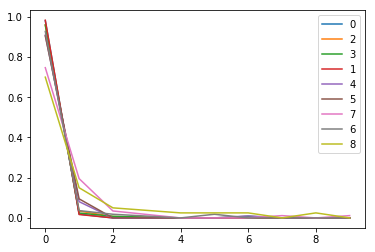


Analisi Bivariata days-comment_count 



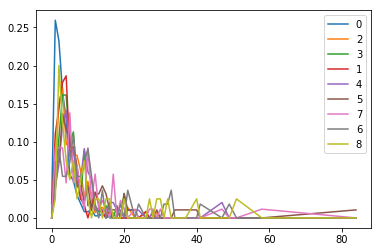


Analisi Bivariata days-description_length 



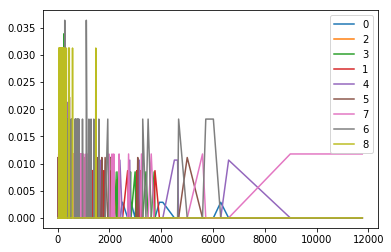


Analisi Bivariata days-summary_length 



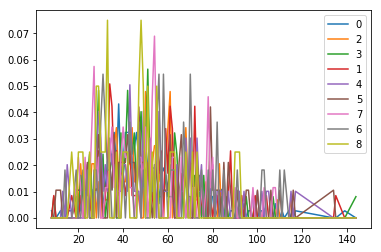


Analisi Bivariata days-watch_count 



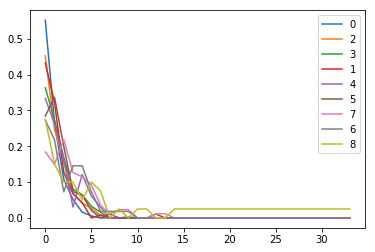

In [452]:
for c in numerical_cols:
    
    c_uniques = df[c].unique()
    if len(c_uniques) >= len(days_uniques):
        x = df["binned"].get_values()
        y = df[c].values
        
    else:
        x = df[c].values
        y = df["binned"].get_values()
        
    confusion_matrix = df.groupby([y, x]).size().sort_values(ascending = False).unstack(fill_value=0)
    confusion_matrix = confusion_matrix.reindex_axis(confusion_matrix.sum().sort_values(ascending = False).index, axis=1)
    
    confusion_matrix = confusion_matrix / confusion_matrix.sum()
    print("\n\033[1m" + "Analisi Bivariata days" + "-" + c + "\033[0;0m \n")
    confusion_matrix.plot.line()
    

    plt.show()

References
- https://www.kaggle.com/residentmario/bivariate-plotting-with-pandas
- https://www.kaggle.com/residentmario/univariate-plotting-with-pandas
- https://www.kaggle.com/residentmario/plotting-with-seaborn/

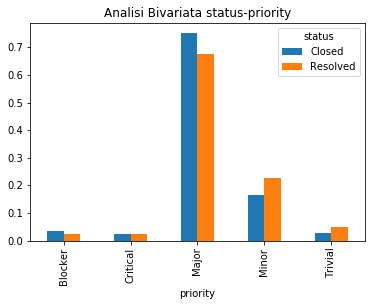

In [261]:
x = 'status'
y = 'priority'

confusion_matrix = df.groupby([y, x]).size().sort_values(ascending = False)[:30].unstack(fill_value=0)
confusion_matrix = confusion_matrix.reindex_axis(confusion_matrix.sum().sort_values(ascending = False).index, axis=1)

confusion_matrix = confusion_matrix / confusion_matrix.sum()
 

confusion_matrix.plot.bar(title = "Analisi Bivariata " + x + "-" + y)


priority     Major  Minor  Blocker  Trivial  Critical
issue_type                                           
Bug            379     68       27       13        22
Improvement    283     95        7       15         4
New Feature    124     21        2        2         0
Sub-task        31      0        1        0         0
Task             7      2        1        1         2
Test            18      3        0        0         0
Wish             6      0        0        0         0


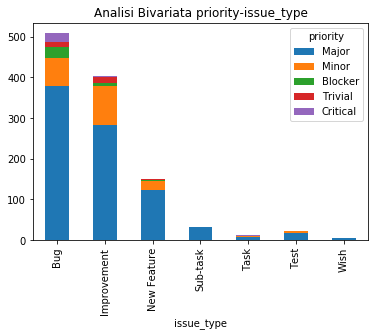

In [272]:
y = 'issue_type'
x = 'priority'

confusion_matrix = df.groupby([y, x]).size().sort_values(ascending = False)[:30].unstack(fill_value=0)
confusion_matrix = confusion_matrix.reindex_axis(confusion_matrix.sum().sort_values(ascending = False).index, axis=1)

confusion_matrix.plot.bar(title = "Analisi Bivariata " + x + "-" + y, stacked= True)
print(confusion_matrix)

In [274]:
confusion_matrix.sum(axis = 1)

issue_type
Bug            509
Improvement    404
New Feature    149
Sub-task        32
Task            13
Test            21
Wish             6
dtype: int64

priority        Major     Minor   Blocker   Trivial  Critical
issue_type                                                   
Bug          0.446934  0.359788  0.710526  0.419355  0.785714
Improvement  0.333726  0.502646  0.184211  0.483871  0.142857
New Feature  0.146226  0.111111  0.052632  0.064516  0.000000
Sub-task     0.036557  0.000000  0.026316  0.000000  0.000000
Task         0.008255  0.010582  0.026316  0.032258  0.071429
Test         0.021226  0.015873  0.000000  0.000000  0.000000
Wish         0.007075  0.000000  0.000000  0.000000  0.000000


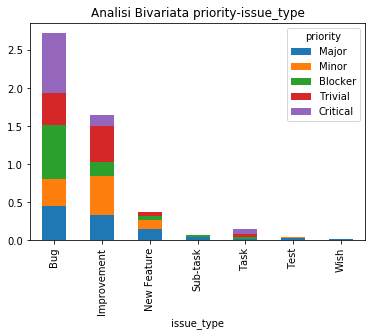

In [271]:

confusion_matrix = confusion_matrix / confusion_matrix.sum()
confusion_matrix.plot.bar(title = "Analisi Bivariata " + x + "-" + y, stacked= True)
print(confusion_matrix)

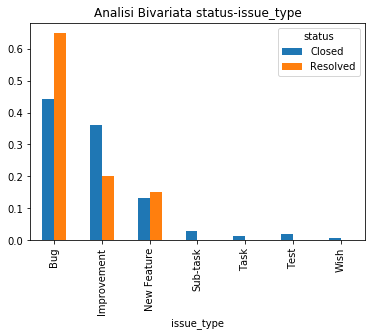

In [264]:
y = 'issue_type'
x = 'status'

confusion_matrix = df.groupby([y, x]).size().sort_values(ascending = False)[:30].unstack(fill_value=0)
confusion_matrix = confusion_matrix.reindex_axis(confusion_matrix.sum().sort_values(ascending = False).index, axis=1)

confusion_matrix = confusion_matrix / confusion_matrix.sum()
 

confusion_matrix.plot.bar(title = "Analisi Bivariata " + x + "-" + y)

In [ ]:
#import numpy
#numpy.corrcoef(list1, list2)[0, 1]

df[numerical_cols[i]].values

In [ ]:
df.sample(100).plot.scatter(x=numerical_cols[i], y= numerical_cols[j])
df.plot.hexbin(x=numerical_cols[i], y= numerical_cols[j], gridsize=20, sharex= False)

In [ ]:
# categorica/numerica A - categorica B (ma B deve avere un numero limitato di valori possibili)
confusion_matrix = df.groupby(["priority", "issue_type"]).size().sort_values(ascending = False).unstack(fill_value=0)
confusion_matrix = confusion_matrix.reindex_axis(confusion_matrix.sum().sort_values(ascending = False).index, axis=1)
cols = confusion_matrix.columns[:15]
#confusion_matrix[cols]
confusion_matrix = confusion_matrix / confusion_matrix.sum()

In [ ]:
confusion_matrix

In [ ]:
confusion_matrix.plot.bar(stacked=True)

In [ ]:
confusion_matrix.plot.bar()

In [ ]:
confusion_matrix.plot.line()

In [ ]:
df.plot.hexbin(y=numerical_cols[i], x= "issue_type", gridsize=20, sharex= False)

In [ ]:
confusion_matrix

In [ ]:
df['binned'] = pd.cut(df['closing_time'], bins=bins, labels =)
df.groupby([ "resolution", "binned"]).size()

In [ ]:
df["diff_created_updated"] = df['resolutiondate'] - df["updated"]
df["diff_created_updated"] = df["diff_created_updated"].astype('timedelta64[D]')
df[df["diff_created_updated"] > 0].shape

In [ ]:
df[df["closing_time"] > 700][["status", "priority", "issue_type", "created", "updated","resolutiondate", "closing_time",  "diff_created_updated"]]

### Variabile Dipendente STATUS

Osserviamo che la variabile è caratterizzata da 5 categorie distinte. Il dataset risulta sbilanciato rispetto a questa variabile. 

In [ ]:
#col = "status"
#print(df["status"].describe(include=['O']))

count = df[col].value_counts()
print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
print (count[:20])

df[col].value_counts().plot(kind='bar')

### Variabile Resolution

In [ ]:
df.groupby(["status", "resolution"]).size()

In [ ]:
df[~df['resolutiondate'].isnull()].shape

In [ ]:
df["has_res_date"] = ~df['resolutiondate'].isnull()

In [ ]:
df.groupby(["status", "has_res_date"]).size()

In [ ]:
df.describe()

In [ ]:
#Filter categorical variables
categorical_columns = [x for x in df.dtypes.index if df.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['key','project']]
#Print frequency of categories
for col in categorical_columns:
    count = df[col].value_counts()
    print ('\nFrequency of %d Categories for varible %s'%(len(count), col))
    print (count.head(20))
    print("...")

### Analisi Univariata

Il dataset si compone di 17 attributi, 7 categorici e 9 numerici

**Attributi categorici**
- Status, è caratterizzato da 5 valori distinti ()
- Priority, è caratterizzato da 5 valori distinti 
- Issue_type, è caratterizzato da 7 valori distinti 
- Reporter, è caratterizzato da 343 valori distinti
- Project, monovalore. Verrà rimosso
- assignee, 152 valori distinti;
- Key, 1458 valori distinti (rappresenta il sequence id del dataset). Poco significativo, verrà rimosso nelle analisi successive;
- Resolution, 8 valori distinti